## 准备模型(可以用ATC的命令行转也可以用MindStudio调用ATC转换）

In [1]:
ls ./model

0_BatchMatMul_0_0_1_1_1024_1024_0_0_1_1_1024_27648_0_0_1_1_1024_27648.om
0_BatchMatMul_0_0_1_1_1024_1024_0_0_1_1_1024_3072_0_0_1_1_1024_3072.om
hifill_34.om*
hifill.om
matmul_paint_3072.om*
matmul_paint.om*
matmultst.om*


## 导入numpy和opencv

In [2]:
import numpy as np
import cv2
import time

## 读入要处理的数据，原始图片以及mask

In [3]:
raw_img = cv2.imread('./data/testset/20.jpg') 
raw_mask = cv2.imread('./mask/maskset/20.jpg') 

In [4]:
print(type(raw_img))
print(raw_img.shape)
print(type(raw_mask))
print(raw_mask.shape)

<class 'numpy.ndarray'>
(3456, 5184, 3)
<class 'numpy.ndarray'>
(3456, 5184, 3)


## 高清原始图(4000x6000)

In [5]:
from matplotlib import pyplot as plt
plt.imshow(raw_img)
# cv2.imshow('raw_img', raw_img)

## mask也是一样的大小，以0或者1表示图片中需要修复的部分

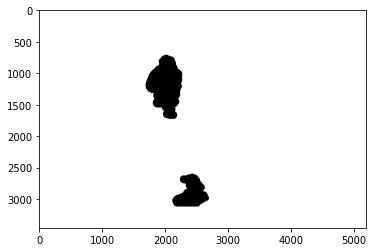

In [6]:
plt.imshow(raw_mask)

## 定义输出路径，模型文件等变量

In [7]:
OUTPUT_DIR = './out/'
MODEL_PATH = "./model/hifill_34.om"
MODEL_MATMUL_PATH = "./model/matmul_paint_3072.om"
#MODEL_MATMUL_PATH = "./model/matmultst.om"
# 模型输入图像的尺寸
MODEL_WIDTH = 512
MODEL_HEIGHT = 512

INPUT_SIZE = 512
# 将图像划分成32*32的网格，然后去计算注意力矩阵
ATTENTION_SIZE = 32 

# 
MULTIPLE = 6

# 模型输入需要时float32类型的数据
NPTYPE_FLOAT32 = np.float32

## 对原始大图进行下采样, 先将原始大图缩放（线性插值）到3072 x 3072，再下采样到512 x 512
## 下采样方法：自定义的分块平均法（6x6）

In [8]:
# extract image patches
def extract_image_patches(img, multiple):
    # (6*512  6*512  3)
    h, w, c = img.shape
    # (512  6 512 6 3)
    img = np.reshape(img, [h//multiple, multiple, w//multiple, multiple, c])
    # (512  512 6 6 3)
    img = np.transpose(img, [0,2,1,3,4])
    return img

In [9]:
def resize_ave(img, MULTIPLE):
    img = img.astype(NPTYPE_FLOAT32)
    img_patches = extract_image_patches(img, MULTIPLE)
    # (512 512 3)
    img = np.mean(img_patches, axis=(2,3))
    return img

In [10]:
def pre_process(raw_img, raw_mask):
    raw_mask = raw_mask.astype(NPTYPE_FLOAT32) / 255.
    raw_img = raw_img.astype(NPTYPE_FLOAT32)

    # resize raw image & mask to desinated size,(6*512  6*512)
    large_img = cv2.resize(raw_img,  (MULTIPLE * INPUT_SIZE, MULTIPLE * INPUT_SIZE), interpolation = cv2.INTER_LINEAR)
    large_mask = cv2.resize(raw_mask, (MULTIPLE * INPUT_SIZE, MULTIPLE * INPUT_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # down-sample large image & mask to 512x512
    # 这里用到的是自定义的下采样方法（每6x6个像素做平均）
    small_img = resize_ave(large_img, MULTIPLE)
    small_mask = cv2.resize(raw_mask, (INPUT_SIZE, INPUT_SIZE), interpolation = cv2.INTER_NEAREST)
    
    # set hole region to 1. and backgroun to 0.
    small_mask = 1. - small_mask
    
    small_img = np.ascontiguousarray(small_img)
    
    return large_img, large_mask, small_img, small_mask

## img_large: 3072x3072,  mask_large: 3072*3072
## img_512和mask_512: 模型的输入

In [11]:
img_large, mask_large, img_512, mask_512 = pre_process(raw_img, raw_mask)

In [12]:
print(type(img_large[1][1][1]))

<class 'numpy.float32'>


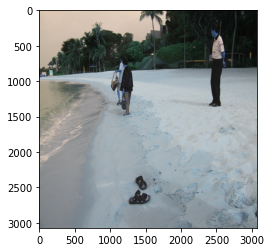

In [13]:
plt.imshow(img_large.astype(np.uint8))

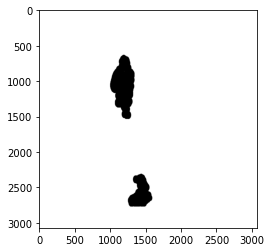

In [14]:
plt.imshow(mask_large)

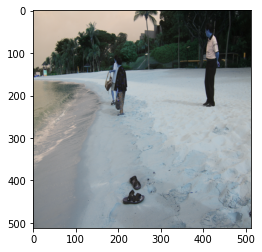

In [15]:
plt.imshow(img_512.astype(np.uint8))

(512, 512, 3)
[0. 0. 0.]


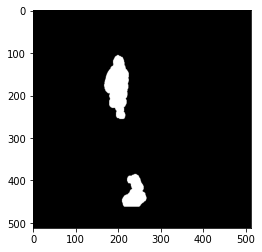

In [16]:
plt.imshow(mask_512)
print(mask_512.shape)
print(mask_512[1][1])

## 对mask进行一个处理，改成灰度图

In [17]:
mask_512_hwc = mask_512[:,:,0:1]
mask_512_hwc = mask_512_hwc.transpose(2,0,1).copy()  

In [18]:
print(mask_512_hwc.shape)

(1, 512, 512)


# 接下来开始申请计算资源，加载模型，进行推理

In [21]:
import sys
import acl

atlas_path = "/home/HwHiAiUser/mhc/paintfix_python/atlas_utils"
sys.path.append(atlas_path)

from atlas_utils.constants import *
from atlas_utils.utils import *

from acl_model import Model

acl.init()
ret = acl.init()
ret = acl.rt.set_device(0)

# 可以显示的创建context，stream，也可以不创建，使用默认的。
# context, ret = acl.rt.create_context(0)
# stream, ret = acl.rt.create_stream()

run_mode, ret = acl.rt.get_run_mode()
print(run_mode)

1


## 加载模型并初始化模型所需要的资源

In [22]:
model = Model(run_mode, MODEL_PATH)

load model  ./model/hifill_34.om
Init model resource
[Model] create model output dataset:
[Model] create model output dataset success
[Model] class Model init resource stage success


## 执行推理，得到三个输出：修复了mask部分后的图像；切分成32x32个小块后，小块与小块之间的关联矩阵（注意力矩阵）；新的mask(对边缘做了处理使得结果更平滑）

In [23]:
resultList  = model.execute([img_512, mask_512_hwc])        
inpainted_512 = resultList[0]  
attention = resultList[1]
mask_512_new = resultList[2] 

acl.mdl.execute exhaust  0:00:00.118077


<class 'numpy.ndarray'>
(1, 512, 512, 3)


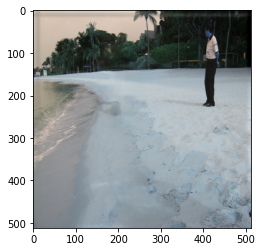

In [24]:
print(type(inpainted_512))
print(inpainted_512.shape)
plt.imshow(inpainted_512[0].astype(np.uint8))  

In [25]:
print(type(attention))
print(attention.shape)

<class 'numpy.ndarray'>
(1, 32, 32, 1024)


<class 'numpy.ndarray'>
(1, 512, 512, 1)


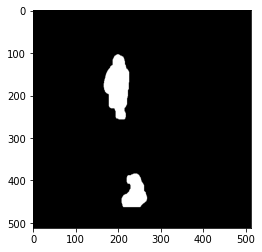

In [26]:
print(type(mask_512_new))
print(mask_512_new.shape)
plt.imshow(mask_512_new[0].astype(np.uint8),cmap='gray')  

## 加载矩阵乘模型

In [27]:
matmul_model = Model(run_mode,MODEL_MATMUL_PATH)

load model  ./model/matmul_paint_3072.om
Init model resource
[Model] create model output dataset:
[Model] create model output dataset success
[Model] class Model init resource stage success


## 矩阵乘执行

In [28]:
def matmul_om(matmul_model,attention,residual):
    attention_reshape = attention.reshape(1024,1024)
    print("print(attention_reshape.shape)",attention_reshape.shape)
    residual_reshape = residual.reshape(1024,3072*9)
    result = []
    matmul_tmp = []
    for i in range(9):
        resi = residual_reshape[:,i*3072:(i+1)*3072]
        resi_tmp = resi.copy()
        matmul_ret = matmul_model.execute([attention_reshape,resi_tmp])
        tmp = matmul_ret[0]
        result.append(tmp.reshape(1024,3072))
        #result.append(copy.deepcopy(tmp.reshape(1024,3072)))
    return np.hstack(result).reshape(ATTENTION_SIZE,ATTENTION_SIZE,3072*9)

In [29]:
# 重建残差，其实就是reshape后再转置回去，3072*3072*3
def reconstruct_residual_from_patches(residual, multiple):
    residual = np.reshape(residual, [ATTENTION_SIZE, ATTENTION_SIZE, multiple, multiple, 3])
    residual = np.transpose(residual, [0,2,1,3,4])
    return np.reshape(residual, [ATTENTION_SIZE * multiple, ATTENTION_SIZE * multiple, 3])

## 残差聚合，通过关联矩阵，对残差进行修复

In [30]:
def residual_aggregate(model,residual, attention):
    # residual： 3072*3072*3，MULTIPLE * INPUT_SIZE//ATTENTION_SIZE： 96 
    # 将大图也按照32*32划分成小块（每96*96个像素为一个小块） 结果：（32 32 96 96 3）
    residual = extract_image_patches(residual, MULTIPLE * INPUT_SIZE//ATTENTION_SIZE)
    
    # 结果：（1024，96*96*3），相当于是对于每个patch，将（96*96*3）展开，变成一个很宽的大矩阵！
    residual = np.reshape(residual, [1, residual.shape[0] * residual.shape[1], -1])
    
    # 将注意力矩阵与残差相乘，得到残差的修复图（特别是mask内的部分：每个像素都被背景给填充上了）
    residual = matmul_om(model,attention,residual)
    #residual = np.matmul(attention, residual)
    residual = reconstruct_residual_from_patches(residual, MULTIPLE * INPUT_SIZE//ATTENTION_SIZE)
    return residual

## 后处理，对GAN网络生成的结果，对残差进行修复，得到mask内的清晰图片，叠加到原图中

In [31]:
def post_process(model,raw_img, large_img, large_mask, inpainted_512, img_512, mask_512, attention):
    # compute the raw residual map
    s = time.time()
    h, w, c = raw_img.shape
    # inpainted_512 inference result.
    # low_base = cv2.resize(inpainted_512.astype(NPTYPE_FLOAT32), (INPUT_SIZE * MULTIPLE, INPUT_SIZE * MULTIPLE), interpolation = cv2.INTER_LINEAR) 
    # img_512 preprocess result.
    low_large = cv2.resize(img_512.astype(NPTYPE_FLOAT32), (INPUT_SIZE * MULTIPLE, INPUT_SIZE * MULTIPLE), interpolation = cv2.INTER_LINEAR)
    residual = (large_img - low_large) * large_mask

    
    print('post_process before time', time.time() - s)
    # reconstruct residual map using residual aggregation module
    residual = residual_aggregate(model,residual, attention)
    print('post_process residual_aggregate time', time.time() - s)
    # compute large inpainted result
    # inpainted_512 inference result.
    low_base = cv2.resize(inpainted_512.astype(NPTYPE_FLOAT32), (INPUT_SIZE * MULTIPLE, INPUT_SIZE * MULTIPLE), interpolation = cv2.INTER_LINEAR) 
    res_large = low_base + residual
    res_large = np.clip(res_large, 0., 255.)

    # resize large inpainted result to raw size
    res_raw = cv2.resize(res_large, (w, h), interpolation = cv2.INTER_LINEAR)
    
    # paste the hole region to the original raw image
    mask = cv2.resize(mask_512.astype(NPTYPE_FLOAT32), (w, h), interpolation = cv2.INTER_LINEAR)
    mask = np.expand_dims(mask, axis=2)
    
    res_raw = res_raw * mask + raw_img * (1. - mask)
    return res_raw.astype(np.uint8)

In [32]:
print(type(matmul_model))

<class 'acl_model.Model'>


In [33]:
s = time.time()
res_raw_size = post_process(matmul_model,raw_img, img_large, mask_large, inpainted_512[0], img_512, mask_512_new[0], attention[0])
filename = './out/outpaint_20.jpg'
cv2.imwrite(filename , res_raw_size)
print('processing time', time.time() - s)

post_process before time 0.10068225860595703
print(attention_reshape.shape) (1024, 1024)
acl.mdl.execute exhaust  0:00:00.003385
acl.mdl.execute exhaust  0:00:00.003208
acl.mdl.execute exhaust  0:00:00.003191
acl.mdl.execute exhaust  0:00:00.003116
acl.mdl.execute exhaust  0:00:00.003124
acl.mdl.execute exhaust  0:00:00.003133
acl.mdl.execute exhaust  0:00:00.003166
acl.mdl.execute exhaust  0:00:00.003140
acl.mdl.execute exhaust  0:00:00.003148
post_process residual_aggregate time 0.4358692169189453
processing time 1.510563611984253


In [34]:
print(res_raw_size.shape)

(3456, 5184, 3)


In [35]:
model.destroy()
acl.rt.reset_device(0)
acl.finalize()

Model start release...
Model release source success


0